# Import Modules

In [1]:
%load_ext sql

Tip: You may define configurations in /Users/kul/Dev/featlib/pyproject.toml or /Users/kul/.jupysql/config.

Did not find user configurations in /Users/kul/Dev/featlib/pyproject.toml.

In [2]:
%config SqlMagic.displaylimit = 50

In [3]:
import duckdb
import polars as pl
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib 

# Connect to Local Database

In [4]:

# Create connection to local duckdb database
con = duckdb.connect('../db/duck.db')
%sql con --alias duckdb

In [5]:
%%sql
show tables

Running query in 'duckdb'

name
balance_sheet_assets
balance_sheet_equity
balance_sheet_liabilities
cash_flow_statement
dividend
earnings_calendar
eps_estimate
eps_history
features_cleaned
features_final


# Get features

In [9]:
%%sql
select * from features_final limit 5

Running query in 'duckdb'

date,symbol,adtv_30d,amihud,fwd_return_3m,log_volume,lottery,momentum_10y,momentum_12m,momentum_12m_1m,momentum_5y,momentum_6m,momentum_9m,others_cr,price_to_52w_close_high,price_to_52w_high,vol_vo_p_12m,volatility_bbw,volatility_dcw,volatility_kcw,volatility_ui,volume_adi,volume_nvi,volume_obv,volume_vpt
2020-02-17,VYM,0.04133304965522568,-0.193596757239091,0.051373275464627666,0.8593936820949607,-0.5566499760842789,None,0.10247017894332046,0.08107307310372767,0.05484956329720286,0.023685905016898594,0.09450639354508533,0.24894156617023305,0.757495311859273,0.795700873858913,-0.8878201535317491,-0.7045647782970008,-0.7599446012058216,-0.8398343229282922,-0.6755713194982405,1.2291198692344043,1.4303539296371854,0.06799380419020098,-0.18186286227952222
2012-10-23,SLYV,-0.37217761834253,-0.20998598331655133,0.10400397355234389,-1.1092696637376995,-0.6193267675340112,None,0.01467003423946483,0.07965068686077571,None,-0.03972067782327444,-0.1208486119002599,-0.052409882707238606,0.5690953711651947,0.6097576974636069,0.8663696197204532,-0.589682569342504,-0.32996636305859195,-0.8723548573240156,-0.44542551903833993,-0.17609850255944506,0.049516058811230085,-0.22771591172025157,-0.019870622572815255
2020-03-19,EVRI,0.28551541415028775,-0.23026961629255877,1.7188966671008123,1.317963486104674,0.9918745526524092,None,-1.4010316937506975,0.043673876049069554,-0.7693243939246543,-1.474558502614238,-1.5324429138629805,-0.35528886110680996,-1.9769161914947553,-1.9577153016636037,-0.1124670580400351,1.2217164339953006,1.4324286992718749,1.2953605849832759,1.1586445467419968,-0.09720125271049639,-0.7555474736861532,0.133372798165781,0.10621538191689442
2016-04-26,NMFC,-0.28805682480741596,-0.2090764202481947,0.14597035665389307,0.09856646037216962,-0.8012034202624445,None,-0.24922073845951162,-0.08100362140618217,-0.39184540804618245,-0.4218500213240814,-0.36187442678763143,-0.31623988668507735,0.1573061295608322,0.19878807928354783,-0.39000450816290494,-0.7429966785875476,-0.710812373273245,-0.7423642755672109,-0.31351074099555015,-0.07607632223763741,-0.20106651997456151,-0.26028829657556024,-0.1895174446915392
2016-10-31,EWL,-0.13562501085603598,-0.19705737718095748,-0.2184877327256928,0.6379324527242225,-0.6928384640669324,None,-0.3430440325198173,-0.3264851136933959,-0.24903967300959612,-0.3177791718519531,-0.48923154842290195,-0.1803602102007902,0.39618614539984337,0.45214819911650733,-0.6818584902904249,-0.435939995083048,-0.6043088469518173,-0.9877317598514977,-0.33647216241324923,0.2308928700440877,0.2247455346617549,-0.06709737677921938,-0.10008929661752013


In [53]:
query ="""select * from features_final where date < '2024-01-01' and fwd_return_3m is not null"""
# Load data into pandas dataframe
df = con.execute(query).fetchdf()
df

,date,symbol,adtv_30d,amihud,fwd_return_3m,log_volume,lottery,momentum_10y,momentum_12m,momentum_12m_1m,...,price_to_52w_high,vol_vo_p_12m,volatility_bbw,volatility_dcw,volatility_kcw,volatility_ui,volume_adi,volume_nvi,volume_obv,volume_vpt
0,2020-02-17,VYM,0.041333,-0.193597,0.051373,0.859394,-0.556650,NaN,0.102470,0.081073,...,0.795701,-0.887820,-0.704565,-0.759945,-0.839834,-0.675571,1.229120,1.430354,0.067994,-0.181863
1,2012-10-23,SLYV,-0.372178,-0.209986,0.104004,-1.109270,-0.619327,NaN,0.014670,0.079651,...,0.609758,0.866370,-0.589683,-0.329966,-0.872355,-0.445426,-0.176099,0.049516,-0.227716,-0.019871
2,2020-03-19,EVRI,0.285515,-0.230270,1.718897,1.317963,0.991875,NaN,-1.401032,0.043674,...,-1.957715,-0.112467,1.221716,1.432429,1.295361,1.158645,-0.097201,-0.755547,0.133373,0.106215
3,2016-04-26,NMFC,-0.288057,-0.209076,0.145970,0.098566,-0.801203,NaN,-0.249221,-0.081004,...,0.198788,-0.390005,-0.742997,-0.710812,-0.742364,-0.313511,-0.076076,-0.201067,-0.260288,-0.189517
4,2016-10-31,EWL,-0.135625,-0.197057,-0.218488,0.637932,-0.692838,NaN,-0.343044,-0.326485,...,0.452148,-0.681858,-0.435940,-0.604309,-0.987732,-0.336472,0.230893,0.224746,-0.067097,-0.100089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17490420,2023-11-30,MWG,-0.280497,1.153712,0.402518,-0.748295,1.615830,NaN,NaN,NaN,...,-2.517896,1.129837,1.569757,2.718333,3.417417,3.260511,-0.373400,-0.458794,-0.456054,-0.615592
17490421,2022-10-13,FGI,-0.387340,0.783819,0.179819,-1.217214,-0.230900,NaN,NaN,NaN,...,-1.093920,1.267111,-0.202537,0.262960,0.735161,0.171681,-0.445606,-0.545960,-0.261269,-0.244477
17490422,2022-12-09,MSFU,-0.377217,-0.179185,-0.026611,-1.776988,0.737181,NaN,NaN,NaN,...,0.747864,-0.073920,-0.281400,-0.392350,-0.226771,-0.403291,-0.214572,-0.413184,-0.409612,-0.251078
17490423,2023-02-10,PDBA,-0.388545,-0.035366,0.536307,-1.326919,-0.717568,NaN,NaN,NaN,...,0.998895,1.784396,-0.637411,-0.776733,-1.013008,-0.818915,-0.232741,-0.337869,-0.418713,-0.260121


In [24]:
df.describe()

,date,adtv_30d,amihud,fwd_return_3m,log_volume,lottery,momentum_10y,momentum_12m,momentum_12m_1m,momentum_5y,...,price_to_52w_high,vol_vo_p_12m,volatility_bbw,volatility_dcw,volatility_kcw,volatility_ui,volume_adi,volume_nvi,volume_obv,volume_vpt
count,17665201,1.766520e+07,1.765532e+07,1.749042e+07,1.766520e+07,1.765532e+07,2.980720e+06,1.532223e+07,1.532223e+07,8.736622e+06,...,1.766520e+07,1.765532e+07,1.747805e+07,1.747805e+07,1.757640e+07,1.753702e+07,1.726228e+07,1.766520e+07,1.766520e+07,1.765532e+07
mean,2018-06-05 08:48:09.007375,6.694109e-17,-1.061951e-17,-1.099141e-17,-7.805447e-16,9.050549e-16,6.592148e-17,3.368929e-17,3.852000e-16,-1.974267e-17,...,1.025320e-15,1.958008e-15,-6.409165e-16,-2.805453e-16,-1.912352e-15,8.253985e-17,-1.356859e-16,-1.795704e-17,-4.198771e-17,1.169092e-16
min,2011-01-03 00:00:00,-4.873787e-01,-3.172463e-01,-4.908170e+00,-3.581104e+00,-1.854352e+00,-8.980948e-01,-2.860471e+00,-3.372436e+00,-1.333207e+00,...,-1.472408e+01,-1.451193e+00,-2.736550e+00,-2.554687e+00,-2.878174e+00,-3.335817e+00,-8.965213e+00,-1.354807e+01,-6.456496e-01,-1.407842e+01
25%,2015-06-17 00:00:00,-3.772938e-01,-2.135935e-01,-4.421206e-01,-6.416502e-01,-5.702996e-01,-5.397940e-01,-4.885990e-01,-4.828341e-01,-5.508530e-01,...,-4.522043e-01,-6.878641e-01,-6.126250e-01,-6.270366e-01,-6.996103e-01,-6.394568e-01,-2.644608e-01,-4.485688e-01,-3.626541e-01,-2.407000e-01
50%,2018-11-26 00:00:00,-3.283532e-01,-1.844005e-01,-2.134781e-02,6.781307e-02,-2.987863e-01,-3.184722e-01,-7.122095e-02,-6.807465e-02,-2.344327e-01,...,3.451298e-01,-3.353831e-01,-2.942275e-01,-2.862888e-01,-2.677308e-01,-3.183583e-01,-2.145464e-01,-2.298798e-01,-2.815543e-01,-1.170071e-01
75%,2021-08-23 00:00:00,-1.081973e-01,-1.532012e-01,3.760909e-01,7.135299e-01,2.000707e-01,1.411012e-01,3.233428e-01,3.218671e-01,2.320301e-01,...,7.316336e-01,3.661299e-01,2.740388e-01,3.005188e-01,3.947066e-01,3.026519e-01,-7.780406e-02,1.281344e-01,-1.107597e-01,-4.203146e-02
max,2023-12-29 00:00:00,8.071891e+00,4.612777e+01,7.450692e+00,2.671148e+00,2.455166e+01,8.321617e+00,8.057952e+00,8.379123e+00,8.734279e+00,...,2.410014e+00,6.910532e+00,8.847640e+00,8.979495e+00,8.527780e+00,1.081085e+01,3.602880e+01,5.770971e+01,4.776212e+01,5.677512e+01
std,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999055e-01,1.000000e+00,1.000000e+00


In [25]:
df.shape

(17665201, 25)

# Data Checks

In [35]:
# check for missing values
df.isnull().sum()

date                              0
symbol                            0
adtv_30d                          0
amihud                         9873
fwd_return_3m                     0
log_volume                        0
lottery                        9873
momentum_10y               14540314
momentum_12m                2303379
momentum_12m_1m             2303379
momentum_5y                 8803462
momentum_6m                 1194703
momentum_9m                 1756800
others_cr                         0
price_to_52w_close_high           0
price_to_52w_high                 0
vol_vo_p_12m                   9873
volatility_bbw               186547
volatility_dcw               186547
volatility_kcw                88671
volatility_ui                127882
volume_adi                   388021
volume_nvi                        0
volume_obv                        0
volume_vpt                     9873
dtype: int64

In [33]:
# check for infinite values
df.isin([np.inf, -np.inf]).sum()

date                       0
symbol                     0
adtv_30d                   0
amihud                     0
fwd_return_3m              0
log_volume                 0
lottery                    0
momentum_10y               0
momentum_12m               0
momentum_12m_1m            0
momentum_5y                0
momentum_6m                0
momentum_9m                0
others_cr                  0
price_to_52w_close_high    0
price_to_52w_high          0
vol_vo_p_12m               0
volatility_bbw             0
volatility_dcw             0
volatility_kcw             0
volatility_ui              0
volume_adi                 0
volume_nvi                 0
volume_obv                 0
volume_vpt                 0
dtype: int64

In [ ]:
# Replace infinite values with NaN
# df.replace([float('inf'), -float('inf')], np.nan, inplace=True)

# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df = df.dropna()

In [28]:
# df show rows with inf values

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Filter rows with inf or -inf values in numeric columns
inf_rows = df[np.isinf(numeric_cols).any(axis=1)]

inf_rows

,date,symbol,adtv_30d,amihud,fwd_return_3m,log_volume,lottery,momentum_10y,momentum_12m,momentum_12m_1m,...,price_to_52w_high,vol_vo_p_12m,volatility_bbw,volatility_dcw,volatility_kcw,volatility_ui,volume_adi,volume_nvi,volume_obv,volume_vpt


# ML: Simple

simple pandas train test

In [61]:
# Clone original Polars DataFrame
data = df #.clone()

# Specify features and target
columns = df.columns.tolist()
cols_to_remove = ['date', 'symbol', 'fwd_return_3m']
features = [x for x in columns if x not in cols_to_remove]
target = "fwd_return_3m"

# Prepare the dataset
X = data[features]
y = data[target]

# Convert features to numeric
for col in features:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Clip target to [-1, 1] to handle outliers
# y = y.clip(lower=-3, upper=3)

# # Drop rows with NaN in features
# X = X.dropna()
# y = y.loc[X.index]  # Align the target variable with the remaining rows

# Remove any rows with NaN in the target
# y = y.dropna()
# X = X.loc[y.index]  # Ensure X and y are aligned

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the XGBoost model
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {round(mse,4)}")

# Check MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Median Absolute Error: {round(mae,4)}")

# Baseline MSE
baseline_mse = ((y - y.mean()) ** 2).mean()
print(f"Baseline MSE: {round(baseline_mse,4)}")

/var/folders/yd/36_ylc8x7tx33z1ps2l7yr5r0000gn/T/ipykernel_75513/1341037665.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


Mean Squared Error: 0.9351
Median Absolute Error: 0.6347
Baseline MSE: 1.0


In [62]:
# model performance
round(float(round(baseline_mse,4) - round(mse,4)), 4)

0.0649

In [56]:
print(y.min(), y.max(), y.mean(), y.std())


-4.908170237240128 7.4506924955952645 -1.0873599049396936e-17 1.0000000285870707


# Save Model

In [63]:
# Save model in pickle format
joblib.dump(model, "model_final1.pkl")

['model_final1.pkl']

In [64]:
# Load model
model_loaded = joblib.load("model_final1.pkl")

In [65]:
# Ensure it's fitted
if not hasattr(model_loaded, "feature_importances_"):
    raise ValueError("Model is not fitted. Ensure you loaded the correct model.")

# Model Size

In [66]:
file_path = "model_final1.pkl"  # or .json, .sav, etc.
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {file_size_mb:.2f} MB")

Model size: 0.47 MB


In [67]:
print(f"Number of trees: {model_loaded.get_booster().num_boosted_rounds()}")

Number of trees: 100


In [68]:
print(f"Number of features: {len(model_loaded.feature_importances_)}")

Number of features: 22


In [69]:
import sys
print(f"Memory usage of model: {sys.getsizeof(model_loaded) / (1024 * 1024):.2f} MB")


Memory usage of model: 0.00 MB


In [70]:
def analyze_xgboost_model(model):
    """
    Extracts key parameters from an XGBoost model and provides a size verdict.

    Parameters:
        model (xgboost.XGBRegressor or xgboost.Booster): The trained XGBoost model.

    Returns:
        dict: A dictionary containing model parameters and size verdict.
    """
    # Get model configuration as JSON
    config = json.loads(model.get_booster().save_config())

    # Extract key parameters
    params = {
        "num_trees": int(config["learner"]["gradient_booster"]["gbtree_model_param"]["num_trees"]),
        "num_features": int(config["learner"]["learner_model_param"]["num_feature"]),
        "max_depth": int(config["learner"]["gradient_booster"]["tree_train_param"]["max_depth"]),
        "learning_rate": float(config["learner"]["gradient_booster"]["tree_train_param"]["learning_rate"]),
        "lambda": float(config["learner"]["gradient_booster"]["tree_train_param"]["lambda"]),
        "alpha": float(config["learner"]["gradient_booster"]["tree_train_param"]["alpha"]),
        "objective": config["learner"]["learner_train_param"]["objective"],
        "base_score": float(config["learner"]["learner_model_param"]["base_score"]),
    }

    # Determine model size category
    if params["num_trees"] > 500 or params["num_features"] > 200 or params["max_depth"] > 10:
        size_verdict = "Large"
    elif params["num_trees"] > 200 or params["num_features"] > 100 or params["max_depth"] > 6:
        size_verdict = "Medium"
    else:
        size_verdict = "Small"

    params["size_verdict"] = size_verdict  # Add verdict to parameters

    return params  # Return extracted parameters with size verdict

# Example Usage:
model_params = analyze_xgboost_model(model_loaded)
print(model_params)


{'num_trees': 100, 'num_features': 22, 'max_depth': 6, 'learning_rate': 0.100000001, 'lambda': 1.0, 'alpha': 0.0, 'objective': 'reg:squarederror', 'base_score': 0.00014172093, 'size_verdict': 'Small'}


# Model Performance

Interpretation of Results
Low MSE (Good Sign)

Your error is very small, meaning your model is making accurate predictions.
The training and test errors are very close, which means no overfitting.
Difference Between Training & Test MSE

0.0044 (train) vs. 0.0046 (test)
→ A difference of 0.0002 is negligible, meaning good generalization.
Small Model Size (0.48MB)

Your model is compact and efficient while maintaining high accuracy.

In [71]:
from sklearn.metrics import mean_squared_error

# Predictions on training set
y_train_pred = model_loaded.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)

# Predictions on test set
y_test_pred = model_loaded.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Training MSE: {mse_train:.4f}")
print(f"Test MSE: {mse_test:.4f}")


Training MSE: 0.9350
Test MSE: 0.9351


# Feature Importance

In [72]:
# top 20 features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_loaded.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance.head(20))  # Show top 20 features

                    Feature  Importance
2                log_volume    0.095457
16           volatility_kcw    0.081775
20               volume_obv    0.078190
4              momentum_10y    0.060409
12        price_to_52w_high    0.056307
1                    amihud    0.052454
3                   lottery    0.046158
18               volume_adi    0.044914
21               volume_vpt    0.043923
9               momentum_9m    0.042243
10                others_cr    0.040265
19               volume_nvi    0.040084
5              momentum_12m    0.039024
7               momentum_5y    0.037619
8               momentum_6m    0.034185
6           momentum_12m_1m    0.034184
15           volatility_dcw    0.033350
13             vol_vo_p_12m    0.033083
11  price_to_52w_close_high    0.029680
0                  adtv_30d    0.027319


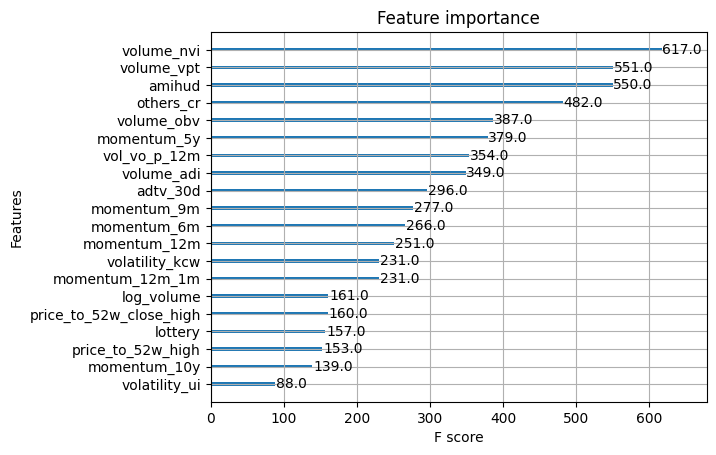

In [73]:
import matplotlib.pyplot as plt

# Counts the number of times a feature appears in splits across all trees.
xgb.plot_importance(model_loaded, importance_type='weight', max_num_features=20)
plt.show()

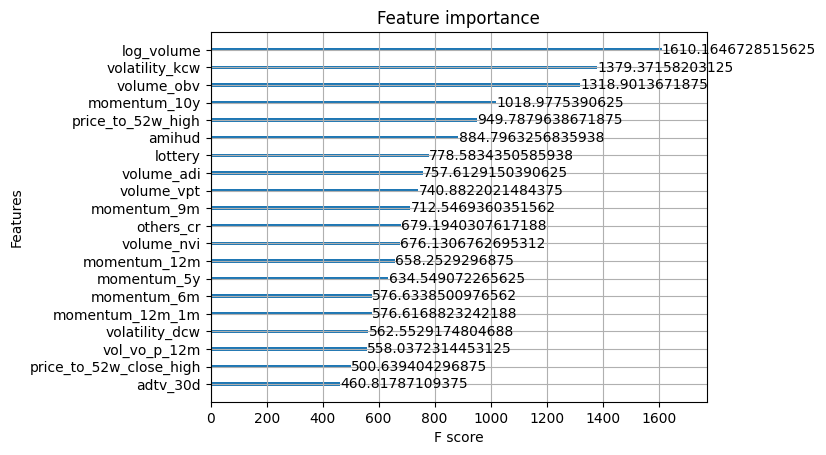

In [74]:
xgb.plot_importance(model_loaded, importance_type='gain',  max_num_features=20)
plt.show()

# Hyperparameter Tuning

In [75]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [17]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

model = XGBRegressor()
search = RandomizedSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_iter=10)
search.fit(X_train, y_train)

# print(search.best_params_)


NameError: name 'X_train' is not defined

In [ ]:
print(search.best_params_)

In [ ]:
import sklearn
print(sklearn.__version__)

# Run Model Predictions
- for one date

In [ ]:
query_test ="""select * from features_final where date = '2024-06-04'"""
# Load data into pandas dataframe
# df = con.execute(query).fetchdf()

# con.sql(query)
df_test = con.execute(query_test).fetchdf()
# Replace infinite values with NaN
# df_test.replace([float('inf'), -float('inf')], np.nan, inplace=True)
df_test

,date,symbol,adtv_30d,amihud,fwd_return_3m,log_volume,lottery,momentum_10y,momentum_12m,momentum_12m_1m,...,price_to_52w_high,vol_vo_p_12m,volatility_bbw,volatility_dcw,volatility_kcw,volatility_ui,volume_adi,volume_nvi,volume_obv,volume_vpt
0,2024-06-04,IWL,-0.306273,-0.373044,0.225348,0.225228,-0.628025,0.443347,0.462967,0.396821,...,0.876188,-0.326708,-0.701188,-0.719132,-0.737795,-0.831332,-0.186232,0.679502,-0.435563,-0.280089
1,2024-06-04,EWBC,-0.215848,-0.373205,0.769192,0.581676,-0.529760,0.111845,0.720502,0.935946,...,0.481673,-0.458382,-0.206775,-0.323672,-0.433965,-0.067408,0.618396,2.862939,0.189594,-0.310042
2,2024-06-04,GEO,0.834520,-0.373137,-0.480438,1.448617,-0.191020,-0.534708,2.363419,2.349685,...,0.605858,-0.898986,0.143883,0.257420,0.036026,-0.023068,-1.167081,-0.363327,0.852885,1.976514
3,2024-06-04,HLNE,-0.296018,-0.372754,1.170061,0.033849,-0.173904,NaN,1.233633,1.212352,...,0.592139,-0.634328,0.035377,-0.140447,0.031967,-0.428288,-0.133359,0.126908,-0.325717,-0.287778
4,2024-06-04,YBTC,-0.338497,-0.365983,-1.138190,-0.310712,-0.389425,NaN,NaN,NaN,...,0.499910,0.151851,-0.058470,-0.124785,0.061601,-0.554213,-0.219006,-0.361632,-0.433489,-0.280584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7255,2024-06-04,VOTE,-0.337455,-0.370724,0.230950,-0.485316,-0.633986,NaN,0.415298,0.362662,...,0.867244,0.168171,-0.716470,-0.732766,-0.745061,-0.810689,-0.175498,-0.232040,-0.416784,-0.279013
7256,2024-06-04,AUSF,-0.336100,-0.367892,0.247890,-0.233730,-0.597167,NaN,0.552088,0.560642,...,0.703473,1.031635,-0.689194,-0.716814,-0.733589,-0.662770,-0.204272,-0.272032,-0.417315,-0.280429
7257,2024-06-04,INMD,-0.165189,-0.372004,-0.629506,0.477577,0.128181,NaN,-1.207058,-1.313520,...,-1.540409,-0.310277,-0.431438,-0.435592,-0.091430,-0.496421,-0.332772,-0.532629,-0.146354,-0.173430
7258,2024-06-04,BCOV,-0.315860,-0.261687,0.176169,-0.002881,-0.002366,-0.635248,-1.199214,-1.583963,...,-1.249277,-0.256493,0.204852,0.085137,0.655925,-0.424798,-0.267313,-0.617504,-0.229847,-0.290446


In [ ]:
# Specify features and target
columns = df_test.columns.tolist()
cols_to_remove = ['date', 'symbol', 'fwd_return_3m']
features = [x for i, x in enumerate(columns) if x not in cols_to_remove] 
target = "fwd_return_3m"

df_test_copy = df_test.copy()

# filter for a single date to predict
df_test_copy = df_test_copy[df_test_copy['date'] == '2024-06-04']

# Extract features only (exclude 'symbol' and 'date')
X_future = df_test_copy[features]  # Ensure feature set matches training

# Predict 3-month forward returns
predicted_returns = model_loaded.predict(X_future)

# Reattach symbol & date for ranking and analysis
df_test_copy['pred_return_3m'] = predicted_returns

# Display ranked results
ranked_stocks = df_test_copy[['date', 'symbol', 'pred_return_3m', 'fwd_return_3m']].sort_values(by='pred_return_3m', ascending=False)

In [152]:
ranked_stocks.head(10)

,date,symbol,pred_return_3m,fwd_return_3m
5424,2024-06-04,LBPH,0.984309,4.159444
4919,2024-06-04,NKTR,0.822133,-0.503637
6867,2024-06-04,AKRO,0.788680,1.884526
926,2024-06-04,EAF,0.783224,-2.545970
852,2024-06-04,AAOI,0.759229,0.521736
2840,2024-06-04,BDTX,0.759165,1.171127
6069,2024-06-04,BVS,0.758150,2.288861
523,2024-06-04,APLT,0.755208,2.300159
3527,2024-06-04,ACRV,0.739418,1.326846
2175,2024-06-04,SST,0.731144,-0.450776


In [143]:
ranked_stocks.head(10)

,date,symbol,pred_return_3m,fwd_return_3m
2359,2024-06-03,LBPH,0.989229,4.178114
3666,2024-06-03,SLNO,0.896494,0.405451
4981,2024-06-03,AAOI,0.834485,-0.232749
7226,2024-06-03,POCI,0.830439,-1.234872
2877,2024-06-03,NKTR,0.822133,-0.517424
6974,2024-06-03,EAF,0.794705,-1.943691
1212,2024-06-03,AKRO,0.788334,1.888872
3899,2024-06-03,KOLD,0.774463,3.067477
6189,2024-06-03,FEBO,0.760991,-2.042795
6610,2024-06-03,CRBP,0.753756,1.107600


In [153]:
%%sql
with cte as (
    select a.*, b.pred_return_3m from features_cleaned a 
    JOIN ranked_stocks b on a.symbol = b.symbol and a.date = b.date
    where a.date = b.date and a.id = 'fwd_return_3m'
    order by b.pred_return_3m desc
    limit 10
)
select * from cte
--select mean(value) from cte

Running query in 'duckdb'

date,symbol,id,value,pred_return_3m
2024-06-04,LBPH,fwd_return_3m,0.9966795794133922,0.9843088984489441
2024-06-04,NKTR,fwd_return_3m,-0.08571428571428563,0.8221333026885986
2024-06-04,AKRO,fwd_return_3m,0.4151925078043705,0.7886804342269897
2024-06-04,EAF,fwd_return_3m,-0.5140845070422535,0.783223569393158
2024-06-04,AAOI,fwd_return_3m,0.12935323383084565,0.7592288851737976
2024-06-04,BDTX,fwd_return_3m,0.26556016597510357,0.7591647505760193
2024-06-04,BVS,fwd_return_3m,0.5000000000000001,0.758150041103363
2024-06-04,APLT,fwd_return_3m,0.5023696682464456,0.7552082538604736
2024-06-04,ACRV,fwd_return_3m,0.29822161422708626,0.739418089389801
2024-06-04,SST,fwd_return_3m,-0.07462686567164185,0.731144368648529


In [80]:
ranked_stocks.tail(11)

,date,symbol,pred_return_3m,fwd_return_3m
4831,2024-03-01,NUTX,-1.486800,-2.612419
4250,2024-03-01,AGRI,-1.563337,-1.207246
5367,2024-03-01,WHLR,-1.567910,-2.212786
3697,2024-03-01,MNTS,-1.600049,-1.159813
5181,2024-03-01,JTAI,-1.617811,-1.386998
752,2024-03-01,NVVE,-1.631785,-1.159050
7030,2024-03-01,VLCN,-1.701566,-2.612419
1363,2024-03-01,BCAN,-1.730342,-2.612419
688,2024-03-01,CYN,-1.752074,-2.010314
4260,2024-03-01,APVO,-1.763409,-2.612419


In [126]:
ranked_stocks.shape

(7200, 4)

In [61]:
%%sql
Select b.security_name, a.* from ranked_stocks a
join symbol b on a.act_symbol = b.act_symbol
order by expected_return_1m desc
--where a.act_symbol = 'AAPL' order by a.date desc limit 10

Running query in 'duckdb'

security_name,act_symbol,date,volume,expected_return_1m,return_1m,return_3m
Fisker Inc. Class A Common Stock,FSR,2024-03-18 00:00:00,291820461.0,0.19623106718063354,None,None
"JOANN, Inc. - common stock",JOAN,2024-03-18 00:00:00,11823665.0,0.1925007849931717,None,None
Golden Minerals Company Common Stock,AUMN,2024-03-18 00:00:00,252749.0,0.16870459914207458,1.2999999999999998,0.5000000000000001
"LivePerson, Inc. - Common Stock",LPSN,2024-03-18 00:00:00,2936407.0,0.1658003181219101,-0.43000000000000005,-0.42000000000000004
Ashford Inc. (Holding Company) Common Stock,AINC,2024-03-18 00:00:00,120290000.0,0.16530871391296387,1.5287958115183249,1.544502617801047
Sunnova Energy International Inc. Common Stock,NOVA,2024-03-18 00:00:00,6733783.0,0.1539326012134552,-0.11238532110091747,0.2545871559633026
"Amylyx Pharmaceuticals, Inc. - Common Stock",AMLX,2024-03-18 00:00:00,5940575.0,0.1447795182466507,-0.29720279720279724,-0.4125874125874126
Sequans Communications S.A. American Depositary Shares (each representing ten (10) Ordinary Shares),SQNS,2024-03-18 00:00:00,397011.2,0.1435878723859787,0.18367346938775497,0.22448979591836726
"Outset Medical, Inc. - Common Stock",OM,2024-03-18 00:00:00,1156939.0,0.14346042275428772,0.040000000000000036,0.9550000000000001
"RAPT Therapeutics, Inc. - Common Stock",RAPT,2024-03-18 00:00:00,796013.0,0.12806805968284607,-0.02400960384153653,-0.5822328931572629


In [154]:
# average return_1m and expected_return_1m of the top 20 stocks
print(ranked_stocks.head(10)['pred_return_3m'].mean())
print(ranked_stocks.head(10)['fwd_return_3m'].mean())

0.788066
1.015231511457275


In [155]:
# average return_1m and expected_return_1m of the bottom 20 stocks
print(ranked_stocks.tail(10)['pred_return_3m'].mean())
print(ranked_stocks.tail(10)['fwd_return_3m'].mean())

-1.850085
-2.8560597466868356


# Close Database Connection

In [156]:
con.close()

In [ ]:
import os

file_path = "xgboost_model.sav"  # or .json, .sav, etc.
file_size_mb = os.path.getsize(file_path) / (1024 * 1024)  # Convert bytes to MB
print(f"Model size: {file_size_mb:.2f} MB")


In [ ]:
print(f"Number of trees: {model.get_booster().num_boosted_rounds()}")


In [88]:
%%sql
WITH day_difference AS (
        SELECT
            *,
            LEAD(date) OVER (PARTITION BY act_symbol ORDER BY date) - date AS day_count
        FROM
            pricing01_inc_splits
        ),
        filtered_symbols AS (
            SELECT
                act_symbol
            FROM
                day_difference
            WHERE
                day_count > 14
            GROUP BY
                act_symbol
        )
        select count(*) from filtered_symbols

Running query in 'duckdb'

count_star()
2637


In [93]:
%%sql
with cte as (
SELECT *, LEAD(date) OVER (PARTITION BY act_symbol ORDER BY date) - date AS day_count
FROM pricing01_inc_splits
)
select * from cte where day_count > 14
AND act_symbol = 'FEDU'

Running query in 'duckdb'

date,act_symbol,open,high,low,close,volume,day_count
2022-11-28,FEDU,8.0,8.0,8.0,8.0,118.0,17
2023-12-12,FEDU,9.73,9.95,9.73,9.75,1034.0,15
2023-12-27,FEDU,9.75,9.75,9.75,9.75,107.0,40


In [95]:
%%sql
select * from pricing01_inc_splits where act_symbol = 'FEDU' and date >= '2023-12-10' order by date asc

Running query in 'duckdb'

date,act_symbol,open,high,low,close,volume
2023-12-12,FEDU,9.73,9.95,9.73,9.75,1034.0
2023-12-27,FEDU,9.75,9.75,9.75,9.75,107.0
2024-02-05,FEDU,8.85,8.85,8.85,8.85,189.0
2024-02-06,FEDU,9.11,9.11,8.5,8.51,677.0
2024-02-07,FEDU,8.22,8.84,8.22,8.84,286.0
2024-02-08,FEDU,8.84,8.84,8.16,8.18,524.0
2024-02-09,FEDU,8.26,8.79,8.26,8.79,804.0
2024-02-13,FEDU,7.78,7.78,7.78,7.78,201.0
2024-02-14,FEDU,8.4,8.4,7.56,7.62,1279.0
2024-02-15,FEDU,7.49,7.6,7.49,7.58,1747.0
